In [89]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import aoflagger

plt.rcParams.update({'font.size': 18})

In [90]:
# h5_file = "20250125-065505_pluto_3state.h5" #MCL LNA ON
# h5_file = "20250125-065951_pluto_3state.h5" #MCL LNA OFF
# h5_file = "20250125-070358_pluto_3state.h5" #50 ohm BNC termination
# h5_file = "20250125-171953_pluto_3state.h5" #New amp first run
# h5_file = "20250125-172644_pluto_3state.h5" #No signalling, cable disconnected
h5_file = "20250125-173034_pluto_3state.h5" #No signalling, cable disconnected, internal COLD load
# h5_file = "20250125-174430_pluto_3state.h5" #Normal connections, but box left open !

In [91]:
print ("Reading",h5_file)
hf = h5py.File(h5_file, 'r')

NFFT = hf["data"].attrs['NFFT']
fc   = hf["data"].attrs['fc']
fs   = hf["data"].attrs['fs']
gain = hf["data"].attrs['gain']
freq = np.linspace(fc-(fs/2), fc+(fs/2), NFFT)/1e6

len_data     = hf["data/timestamps"][()].shape[0]
len_cal_data = int(len_data/3)-1

ant_index  = np.where(hf["data/obssource"][()]==0)[0][0:len_cal_data]
cold_index = np.where(hf["data/obssource"][()]==1)[0][0:len_cal_data]
hot_index  = np.where(hf["data/obssource"][()]==2)[0][0:len_cal_data]

ant_data_raw  = hf["data/radio"][()][ant_index, :]
cold_data_raw = hf["data/radio"][()][cold_index, :]
hot_data_raw  = hf["data/radio"][()][hot_index, :]
# temperature   = hf["data/temperature"][()][ant_index] + 273.15 #Convert to kelvins

ant_tstamps = hf["data/timestamps"][()][ant_index]
print (ant_tstamps[0])
ant_tstamps = ant_tstamps - ant_tstamps[0] #Absolute time irrelevant now

hf.close()

# plt.figure()
# plt.plot(ant_tstamps, temperature)

Reading 20250125-173034_pluto_3state.h5
1737797445.6124375


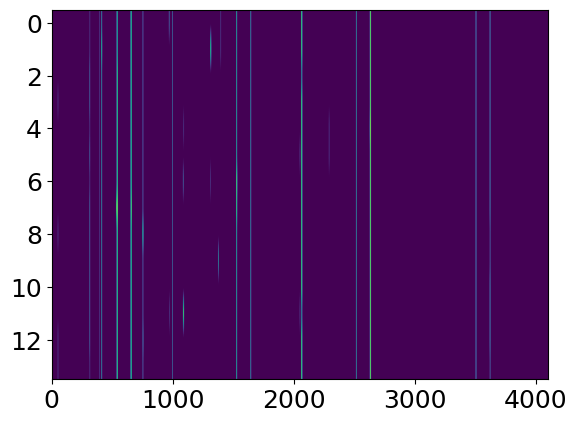

In [92]:
# Flagging section, t5000his ought to be right way (ntimes, nch ordering) to do it

ntimes     = ant_data_raw.shape[0]
nch        = ant_data_raw.shape[1]
flagger    = aoflagger.AOFlagger()
path       = flagger.find_strategy_file(aoflagger.TelescopeId.Generic)
strategy   = flagger.load_strategy_file(path)
data       = flagger.make_image_set(ntimes, nch, 1)

data.set_image_buffer(0, ant_data_raw.T) 
flagvals_ant = strategy.run(data).get_buffer().T

data.set_image_buffer(0, cold_data_raw.T) 
flagvalues_cold = strategy.run(data).get_buffer().T

data.set_image_buffer(0, hot_data_raw.T) 
flagvalues_hot = strategy.run(data).get_buffer().T

flagvalues = np.logical_and(np.logical_and(flagvals_ant, flagvalues_cold), flagvalues_hot)

plt.figure()
plt.imshow(flagvalues, aspect='auto')

ant_data  = np.ma.array(ant_data_raw, mask=(np.array(flagvalues, dtype=bool)))
cold_data = np.ma.array(cold_data_raw, mask=(np.array(flagvalues, dtype=bool)))
hot_data  = np.ma.array(hot_data_raw, mask=(np.array(flagvalues, dtype=bool)))

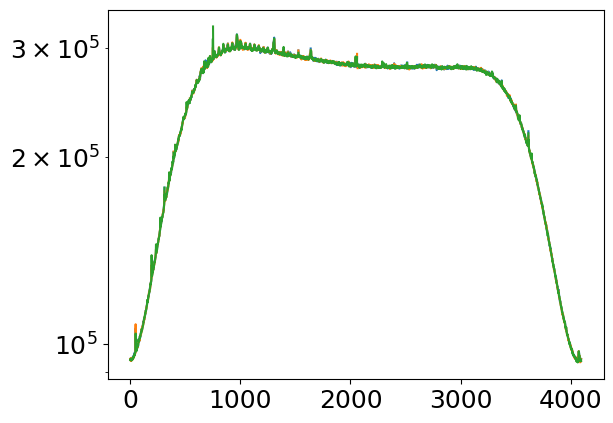

In [93]:
plt.figure()
plt.semilogy(np.ma.mean(ant_data, axis=0))
plt.semilogy(np.ma.mean(cold_data, axis=0))
plt.semilogy(np.ma.mean(hot_data, axis=0))

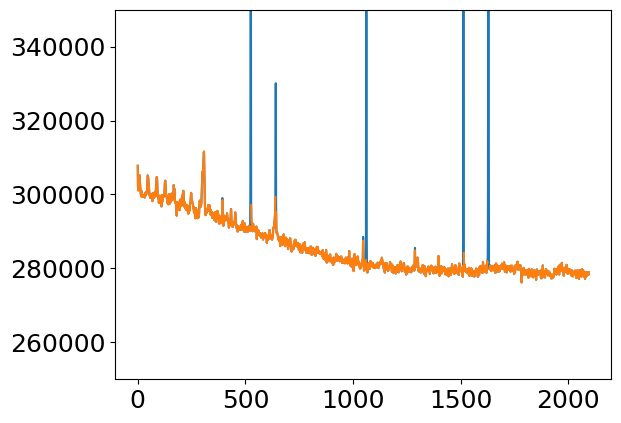

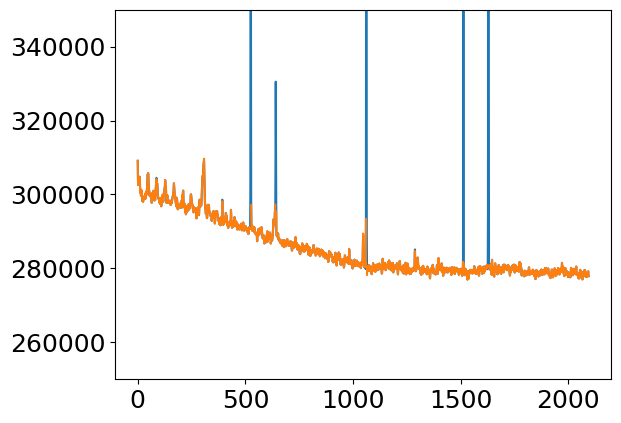

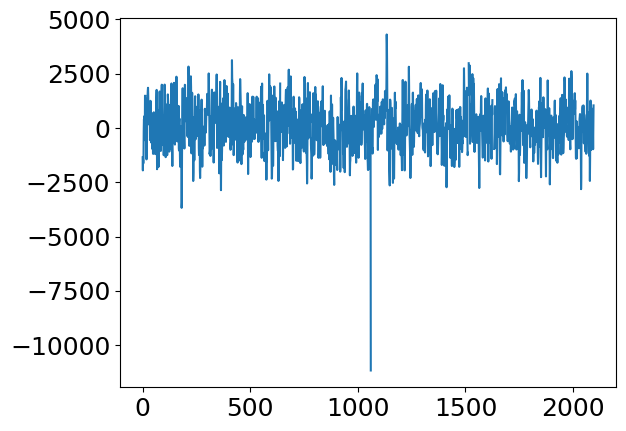

In [94]:
# plt.figure()
# plt.imshow(np.log(ant_data.data), aspect='auto')

plt.figure()
plt.plot(np.mean(ant_data.data, axis=0)[1000:-1000])
plt.plot(np.ma.mean(ant_data, axis=0)[1000:-1000])
plt.ylim(250000, 350000)
# plt.ylim(9000, 10000)

plt.figure()
plt.plot(np.mean(cold_data.data, axis=0)[1000:-1000])
plt.plot(np.ma.mean(cold_data, axis=0)[1000:-1000])
plt.ylim(250000, 350000)

plt.figure()
plt.plot((np.ma.mean(ant_data, axis=0)-np.ma.mean(cold_data, axis=0))[1000:-1000])

In [95]:
T_STEP = 13542 
T_RX = 368 #368.8987704440179

ant_calibrated  = ((ant_data/(hot_data - cold_data))*T_STEP)-T_RX
cold_calibrated = ((cold_data/(hot_data - cold_data))*T_STEP)-T_RX
hot_calibrated  = ((hot_data/(hot_data - cold_data))*T_STEP)-T_RX

mean_ant_power = np.ma.mean(ant_calibrated, axis=1)
mean_cold_power = np.ma.mean(cold_calibrated, axis=1)
mean_hot_power = np.ma.mean(hot_calibrated, axis=1)

mean_ant_spectrum = np.ma.mean(ant_calibrated, axis=0)
mean_cold_spectrum = np.ma.mean(cold_calibrated, axis=0)
mean_hot_spectrum = np.ma.mean(hot_calibrated, axis=0)

7914497.574262975


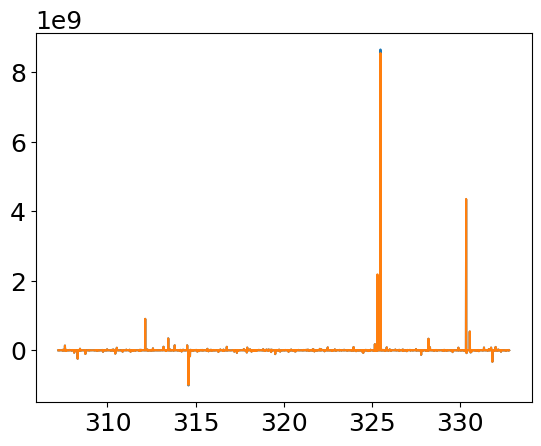

In [96]:
edge_chans = int(1000)

plt.figure()
plt.plot(freq[edge_chans:-edge_chans], mean_ant_spectrum[edge_chans:-edge_chans])
plt.plot(freq[edge_chans:-edge_chans], mean_cold_spectrum[edge_chans:-edge_chans])


mean_ant_temp = np.ma.mean(mean_ant_spectrum[edge_chans:-edge_chans])
print (mean_ant_temp)